# Toxic Comment Classification

## Table of Contents

1. [Introduction](#introduction)
2. [The Data](#data)    
    - [File Description](#file)
3. [Data Wrangling](#wrangling)
4. [Clean the Comments](#clean)
4. [Exploratory Data Analysis](#eda)
    * [Tags](#tags)
    * [Word Frequency with Word Cloud](#wordcloud)
    * [Comment Analyis](#com_analysis)

# <a name="introduction"></a>Introduction
---

Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. Current models don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content). The goal is to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate. 

# <a name="data"></a>The Data
---

The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate


### <a name="file"></a> File descriptions

* **train.csv** - the training set, contains comments with their binary labels
* **test.csv** - the test set, used to predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

# <a name="wrangling"></a>Data Wrangling
---

In this section I am going to load the dataset and look at the columns and some basic DataFrame info.

In [1]:
import pandas as pd

In [2]:
#declare the path of the data
test_data_location = 'data/test.csv'
train_data_location = 'data/train.csv'

#import the data as a DataFramae with 'id' as the index
train_df = pd.read_csv(train_data_location, index_col='id')

In [3]:
#Look at some values in the train DF
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#look at the info of the train DF and its columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [5]:
#fill in any null values
train_df["comment_text"].fillna("unknown", inplace=True)

Now I will create a new DF that will hold stats on the comments such as word counts. This DF will be used later to do some EDA on the comments. This is done before we clean the comments because some features such as puntuation and stopwords will be removed.

# <a name="eda"></a>Exploratory Data Analysis
---

Now that the data is loaded I need to do some EDA. I am going to first look at the tags and then the comments themselves. 

## <a name="tags"></a>Tag Analysis
---

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
count_labels = train_df.iloc[:,1:].sum()
print(count_labels)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [8]:
print('Total tags: ', count_labels.sum())
print('Total comments: ', len(train_df))

Total tags:  35098
Total comments:  159571


Not all comments have been tagged with one of the available tags, this indicates that the comment is not toxic. I am going to create a new column to tag these comments. 

In [9]:
#add up the tags for each comment.
rowsums = train_df.iloc[:,1:].sum(axis=1)

#if the comment has no tags then it is non-toxic
train_df['non_toxic'] = (rowsums==0) #is there a way to add it as 1 or 0 off the bat?

#convert the boolean column to 1 or 0
train_df = train_df.applymap(lambda x: 1 if x == True else x)
train_df = train_df.applymap(lambda x: 0 if x == False else x)

train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [10]:
#update the count labels
count_labels = train_df.iloc[:,1:].sum()
count_labels = count_labels.sort_values()
print(count_labels*100/len(train_df))

threat            0.299553
identity_hate     0.880486
severe_toxic      0.999555
insult            4.936361
obscene           5.294822
toxic             9.584448
non_toxic        89.832112
dtype: float64


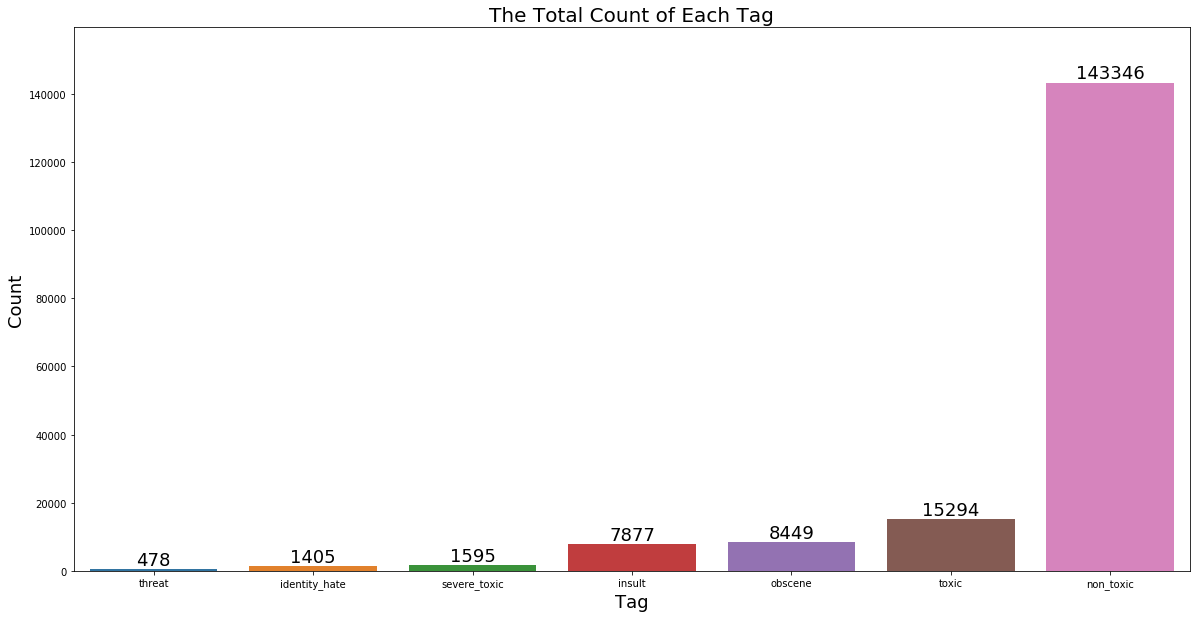

In [11]:
#plot the total to have a better look
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(count_labels.index, count_labels.values)
plt.title("The Total Count of Each Tag", fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Tag', fontsize=18)
plt.ylim(0,len(train_df))

#add the count to the tags
rects = ax.patches
labels = count_labels.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

In [12]:
#Check the total tags and comments again
print('Total tags: ', count_labels.sum())
print('Total comments: ', len(train_df))

Total tags:  178444
Total comments:  159571


There are more tags than total comments, this is most likely due to some comments having multiple tags. I will double check this now.

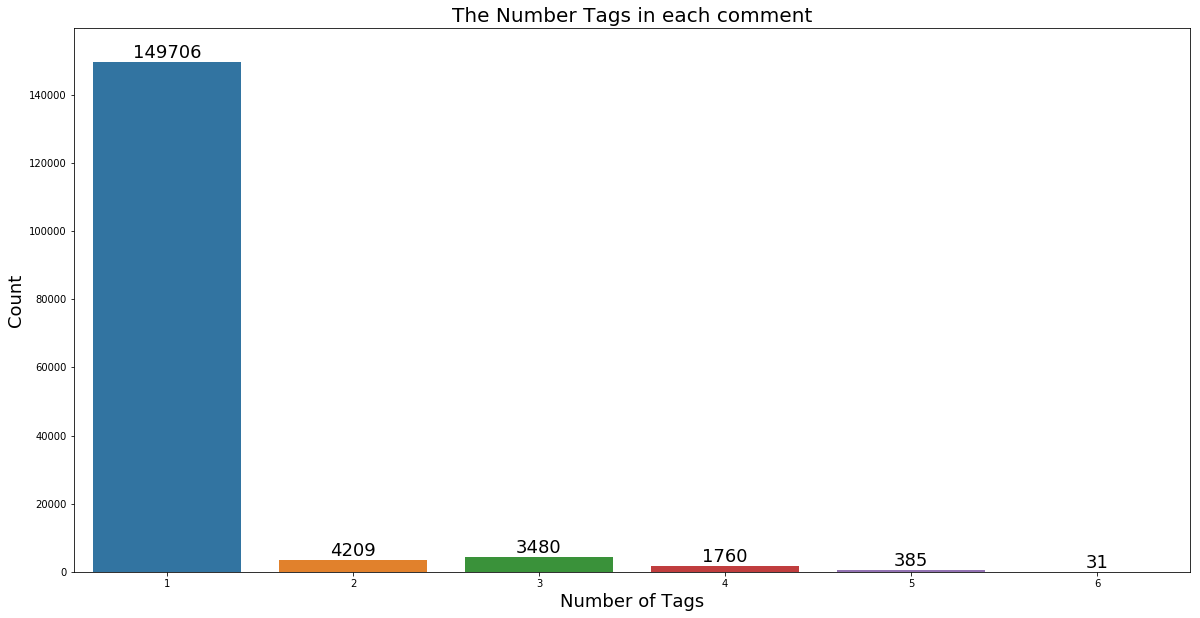

In [13]:
#plot the total count of each 
tag_count = train_df.iloc[:,1:].sum(axis=1).value_counts()
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(tag_count.index, tag_count.values)
plt.title("The Number Tags in each comment", fontsize=20)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Number of Tags', fontsize=18)
plt.ylim(0,len(train_df))

#adding the text labels
rects = ax.patches
labels = tag_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

Indeed there are a lot of comments that have several tags.

## <a name="com_analysis"></a> Comment Analysis
---
Now in this section I am going to explore the comments themselves. To do this I am going to create a new DataFrame in which I am going to store the statistcs of each comments. The stats I am going to gather are the following:
1. sentence count
2. word count
3. unique word count
4. letter count
5. punctuation count
6. upper word count
7. title word count
8. stopwords count
9. mean word length
10. unique word percentage
11. punctuation percentage

In [50]:
#import required packages
import re as regex
import string
import numpy as np
import matplotlib.gridspec as gridspec 

#import nltk
from nltk.corpus import stopwords

eng_stopwords = set(stopwords.words("english"))

In [15]:
#Create the DF
stats_df = train_df.iloc[:,1:]

#Sentense count
stats_df['count_sent'] = train_df["comment_text"].apply(lambda x: len(regex.findall("\n",str(x)))+1)

#Word count
stats_df['count_word'] = train_df["comment_text"].apply(lambda x: len(str(x).split()))

#Unique word count
stats_df['count_unique_word'] = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))

#Letter count
stats_df['count_letters'] = train_df["comment_text"].apply(lambda x: len(str(x)))

#punctuation count
stats_df["count_punctuations"] = train_df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
stats_df["count_words_upper"] = train_df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
stats_df["count_words_title"] = train_df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
stats_df["count_stopwords"] = train_df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
stats_df["mean_word_len"] = train_df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Word count percent
stats_df['word_unique_percent'] = stats_df['count_unique_word']*100/stats_df['count_word']

#Punctuation percent
stats_df['punct_percent'] = stats_df['count_punctuations']*100/stats_df['count_word']

In [16]:
stats_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
id,,,,,,,,,,,,,,,,,,
0000997932d777bf,0,0,0,0,0,0,1,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
000103f0d9cfb60f,0,0,0,0,0,0,1,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
000113f07ec002fd,0,0,0,0,0,0,1,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
0001b41b1c6bb37e,0,0,0,0,0,0,1,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
0001d958c54c6e35,0,0,0,0,0,0,1,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


The DataFrame is missing the 'non_toxic' tag we created earlier so we will go ahead and add it now.

In [17]:
#if the comment has no tags then it is non-toxic
stats_df['non_toxic'] = (rowsums==0) #is there a way to add it as 1 or 0 off the bat?

#convert the boolean column to 1 or 0
stats_df = stats_df.applymap(lambda x: 1 if x == True else x)
stats_df = stats_df.applymap(lambda x: 0 if x == False else x)

stats_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
id,,,,,,,,,,,,,,,,,,
0000997932d777bf,0,0,0,0,0,0,1,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
000103f0d9cfb60f,0,0,0,0,0,0,1,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
000113f07ec002fd,0,0,0,0,0,0,1,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
0001b41b1c6bb37e,0,0,0,0,0,0,1,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
0001d958c54c6e35,0,0,0,0,0,0,1,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538


In [18]:
#Lets reorder the columns so it is easier to plot them.
columns_order = ['toxic','severe_toxic','obscene','threat','insult','identity_hate','non_toxic','count_sent','count_word','count_unique_word','count_punctuations','count_words_upper','count_words_title','count_stopwords','mean_word_len','word_unique_percent','punct_percent', 'count_letters']
stats_df = stats_df[columns_order]

In [19]:
#create a new DF to convert the data into something we can use to plot.
plot_df = pd.DataFrame()
plot_df['toxic'] = stats_df[stats_df.toxic==1].iloc[:,7:].sum()
plot_df['severe_toxic'] = stats_df[stats_df.severe_toxic==1].iloc[:,7:].sum()
plot_df['obscene'] = stats_df[stats_df.obscene==1].iloc[:,7:].sum()
plot_df['threat'] = stats_df[stats_df.threat==1].iloc[:,7:].sum()
plot_df['insult'] = stats_df[stats_df.insult==1].iloc[:,7:].sum()
plot_df['identity_hate'] = stats_df[stats_df.identity_hate==1].iloc[:,7:].sum()
plot_df['non_toxic'] = stats_df[stats_df.non_toxic==1].iloc[:,7:].sum()
plot_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
count_sent,5.092400e+04,7488.000000,2.916100e+04,1670.000000,2.591000e+04,5167.000000,5.071530e+05
count_word,7.844260e+05,120615.000000,4.187370e+05,26369.000000,3.802170e+05,73080.000000,9.879559e+06
count_unique_word,4.894650e+05,34913.000000,2.489290e+05,13364.000000,2.265200e+05,40963.000000,7.135893e+06
count_punctuations,2.197250e+05,47517.000000,1.162900e+05,13226.000000,1.051360e+05,16537.000000,2.298350e+06
count_words_upper,1.392540e+05,53744.000000,8.543500e+04,8774.000000,7.860000e+04,18813.000000,3.322140e+05
count_words_title,9.049600e+04,11892.000000,4.725400e+04,3454.000000,4.175200e+04,7431.000000,1.259369e+06
count_stopwords,3.292000e+05,40494.000000,1.703180e+05,11232.000000,1.567990e+05,26538.000000,4.456899e+06
mean_word_len,7.916395e+04,9664.990058,4.349477e+04,2266.695120,4.073562e+04,8785.339599,7.039446e+05
word_unique_percent,1.341679e+06,130872.036015,7.419877e+05,40420.538887,6.927049e+05,122161.777047,1.222293e+07
punct_percent,6.003434e+05,104562.420430,3.188188e+05,20304.892190,2.960618e+05,40642.880160,4.173483e+06


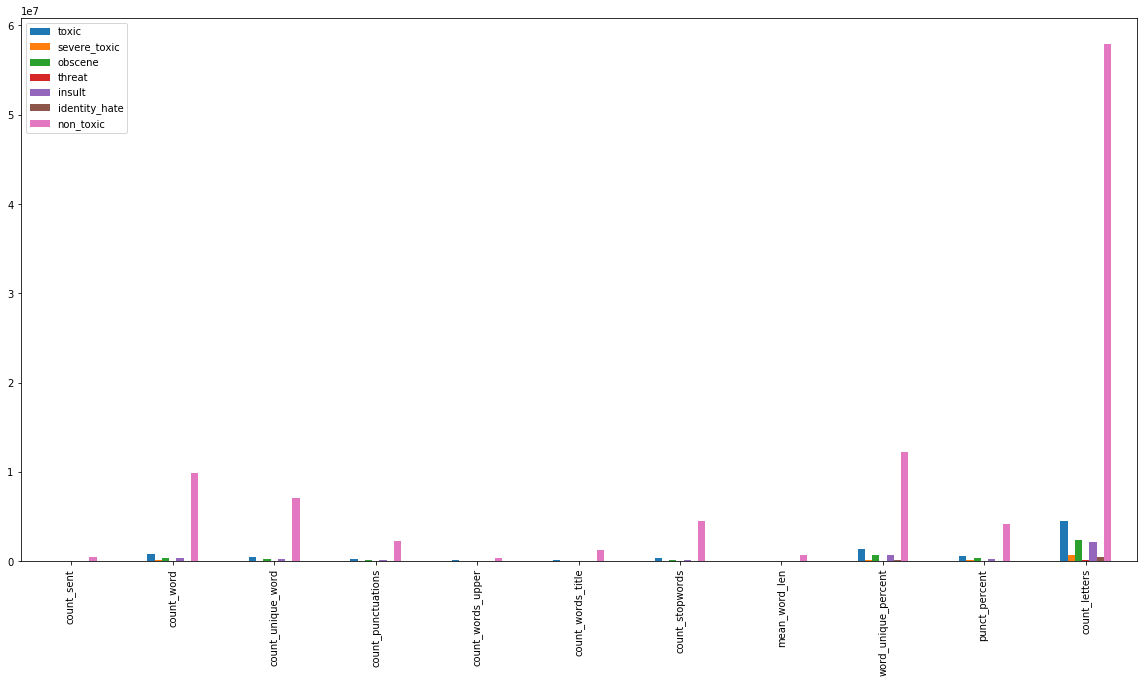

In [20]:
plot_df.plot(kind='bar',figsize=(20,10))
plt.show()

The numbers in the data are to big and its hard to interpert what is happening. The data needs to be normalized to get a better sense of the numbers.

In [21]:
normalized_df = ((plot_df-plot_df.min())/(plot_df.max()-plot_df.min()))
normalized_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
count_sent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003036
count_word,0.164294,0.157985,0.162738,0.169834,0.164163,0.158552,0.165668
count_unique_word,0.098227,0.038300,0.091804,0.080410,0.092950,0.083570,0.118059
count_punctuations,0.037809,0.055902,0.036397,0.079461,0.036708,0.026545,0.034117
count_words_upper,0.019785,0.064598,0.023507,0.048848,0.024413,0.031858,0.000000
count_words_title,0.008864,0.006150,0.007558,0.012267,0.007340,0.005286,0.016088
count_stopwords,0.062330,0.046094,0.058966,0.065750,0.060646,0.049893,0.071573
mean_word_len,0.006325,0.003040,0.005988,0.004103,0.006869,0.008447,0.006450
word_unique_percent,0.289111,0.172310,0.297770,0.266455,0.308950,0.273140,0.206331
punct_percent,0.123062,0.135567,0.120999,0.128137,0.125171,0.082823,0.066655


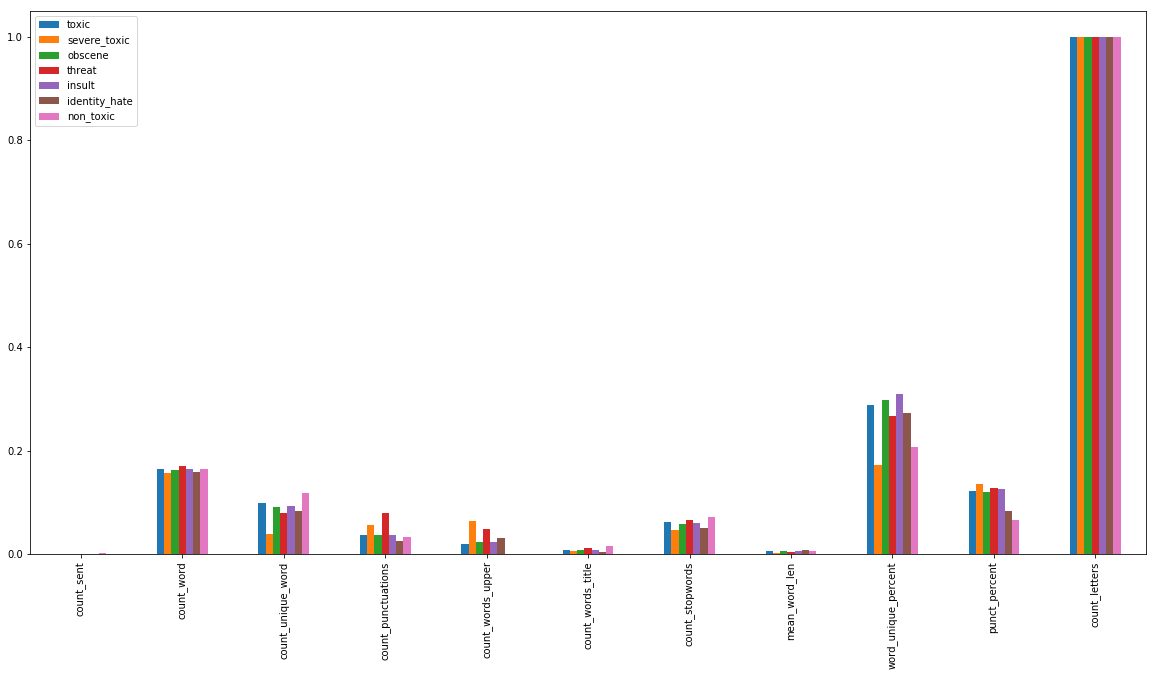

In [22]:
normalized_df.plot(kind='bar',figsize=(20,10))
plt.show()

It looks like the selected features is not indicative of being toxic. The amount of words or puntuation does not mean that you are more or less likely to be toxic.  

# <a name="clean"></a> Clean the Comments
---
In this section I need to clean the comments. This is done by splitting the comments into tokens that we can then lemmatize (or get the root of the word) followed by eliminating any stop words and non-alphabetic elements.

In [23]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm, tqdm_pandas, tqdm_notebook

lem = WordNetLemmatizer()
tqdm.pandas()

In [24]:
def clean_comment(text):
    
    #split into words
    tokens = word_tokenize(text)
    
    #change words to lower case and lemmatize
    stemmed = [lem.lemmatize(word.lower()) for word in tokens]
    
    #remove stop words
    words = [w for w in stemmed if not w in eng_stopwords]
    
    #remove anything non-alphabetic
    clean_words = [word for word in words if word.isalpha()]
    
    #append to string
    clean_comment = " ".join(clean_words)
    
    return clean_comment

In [25]:
train_df.iloc[12235].comment_text

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [26]:
clean_comment(train_df.iloc[12235].comment_text)

'note read follow link reader see cited correctly link added subject vidkun ha added anotations make read oposite link show official line taken ugle trapped user peddle pov strangly mason quiet leaving defend factual truth thanks brother sitting blocking given'

In [27]:
train_df.comment_text = train_df.comment_text.progress_apply(lambda x: clean_comment(x))

100%|████████████████████████████████| 159571/159571 [01:58<00:00, 1346.89it/s]


## <a name="wordcloud"></a>Word Frequency with Word Cloud

---
The word clouds been removed from this notebook as it contains some graphic and vulgar language. If you wish to view the word clouds copy the following code to a new cell and run it. The code snippet to display the word cloud with load into the cell and you can then rerun the cell to view the word clouds. 


%load snippets/wordcloud.py

# Creating the model
---

In this section I will create the model that I will use to predcit the classification of the test_df comments.

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

nb_classifier = MultinomialNB()
count_vectorizer = CountVectorizer(stop_words='english')

In [29]:
#remove any comment with multiple tags
train_df = train_df[train_df.iloc[:,1:].sum(axis=1) == 1]

In [30]:
#To be able to use the the model I want I need to reshape the df. 

#Map the tag into a unique integer
train_df['severe_toxic'] = train_df['severe_toxic'].apply(lambda x: 2 if x == 1 else x)
train_df['obscene'] = train_df['obscene'].apply(lambda x: 3 if x == 1 else x)
train_df['threat'] = train_df['threat'].apply(lambda x: 4 if x == 1 else x)
train_df['insult'] = train_df['insult'].apply(lambda x: 5 if x == 1 else x)
train_df['identity_hate'] = train_df['identity_hate'].apply(lambda x: 6 if x == 1 else x)
train_df['non_toxic'] = train_df['non_toxic'].apply(lambda x: 7 if x == 1 else x)

#create one column with the classification
train_df['classification'] = train_df['toxic']+train_df['severe_toxic']+train_df['obscene']+train_df['threat']+train_df['insult']+train_df['identity_hate']+train_df['non_toxic']
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,classification
id,,,,,,,,,
0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,7,7
000103f0d9cfb60f,match background colour seemingly stuck thanks...,0,0,0,0,0,0,7,7
000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,7,7
0001b41b1c6bb37e,ca make real suggestion improvement wondered s...,0,0,0,0,0,0,7,7
0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,7,7


In [39]:
y = train_df['classification']

X_train, X_test, y_train, y_test = train_test_split(train_df['comment_text'], y, test_size=0.33, random_state=53)

In [42]:
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [43]:
# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

In [44]:
# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1, 2, 3, 4, 5 ,6 ,7])
print(cm)

0.9573912515434285
[[  242     0     0     0     0     0  1636]
 [    0     0     0     0     0     0     0]
 [    7     0     0     0     0     0   106]
 [    1     0     0     0     0     0     7]
 [    8     0     0     0     0     0    87]
 [    0     0     0     0     0     0    15]
 [  234     0     3     1     0     0 47056]]


Verifying the model

In [45]:
train_df.loc[['0000997932d777bf']].comment_text

id
0000997932d777bf    explanation edits made username hardcore metal...
Name: comment_text, dtype: object

In [47]:
txt = count_vectorizer.transform(train_df.loc[['0000997932d777bf']].comment_text)

In [48]:
pred_text = nb_classifier.predict(txt)
pred_text

array([7], dtype=int64)